In [15]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [1]:
import pymongo
import pandas as pd
from pymongo import MongoClient
client = MongoClient()
db = client.performance_dashboard

In [2]:
%matplotlib inline
from bokeh.io import output_notebook
output_notebook()

import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

Loading BokehJS ...

In [3]:
import ipywidgets as widgets
from IPython.display import display

components = db.benchmark_results.distinct("component")

def update_benchmark_name(component):
    benchmark_names = db.benchmark_results.find({"component": component}).distinct("benchmark_name")
    benchmark_name_selection.options = benchmark_names
    pass

def update_benchstep_name(benchmark_name):
    component = component_selection.value
    benchmark_name = benchmark_name_selection.value
    benchstep_names = db.benchmark_results.find({"component": component,
                                                 "benchmark_name": benchmark_name
                                                }
                                               ).distinct("benchstep_name")
    benchstep_name_selection.options = benchstep_names
    pass
   
def update_versions(benchstep_name):
    component = component_selection.value
    benchmark_name = benchmark_name_selection.value
    versions = db.benchmark_results.find({"component": component,
                                          "benchmark_name": benchmark_name,
                                          "benchstep_name": benchstep_name,
                                         }
                                        ).distinct("version")
    versions.sort(reverse=True)
    versions_selection.options = versions
    versions_selection.selected_labels = []

def print_versions(versions):
    pass
    
 
component_selection = widgets.Dropdown(description="Component", options=components, value='Ocean')
benchmark_name_selection = widgets.Dropdown(description="Benchmark name", options=[])
benchstep_name_selection = widgets.Dropdown(description="Step name", options=[])
versions_selection = widgets.SelectMultiple(description="Version")

i = widgets.interactive(update_benchmark_name, component=component_selection)
j = widgets.interactive(update_benchstep_name, benchmark_name=benchmark_name_selection)
k = widgets.interactive(update_versions, benchstep_name=benchstep_name_selection)
# l = widgets.interactive(print_versions, versions=versions_selection)
display(i)
display(j)
display(k)
display(versions_selection)

In [6]:
from IPython.display import Javascript, display
from ipywidgets import widgets

def run_all(ev):
    global component, benchmark_name, benchstep_name, versions
    component = component_selection.value
    benchmark_name = benchmark_name_selection.value
    benchstep_name = benchstep_name_selection.value
    versions = versions_selection.value

    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Update below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

In [7]:
query = {"component": component, "benchmark_name": benchmark_name, 
         "benchstep_name": benchstep_name, "version": {"$in": versions}}
df = pd.DataFrame.from_records(db.benchmark_results.find(query))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2808 entries, 0 to 2807
Data columns (total 9 columns):
_id                      2808 non-null object
benchmark_name           2808 non-null object
benchstep_name           2808 non-null object
benchstep_result_date    2808 non-null datetime64[ns]
component                2808 non-null object
parameter1               2808 non-null object
revision                 2808 non-null int64
value                    2808 non-null float64
version                  2808 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 219.4+ KB


In [8]:
from bokeh.charts import Scatter
from bokeh.plotting import show
from bokeh.models.formatters import NumeralTickFormatter

title = "{} {} - {}".format(component, benchmark_name, benchstep_name)

p = Scatter(df, x='revision', y='value', color='version', marker='version',
            title=title, legend="top_left",
            xlabel="Revision", ylabel="Time")
p.xaxis[0].formatter = NumeralTickFormatter(format="0")
show(p)

In [9]:
from bokeh.charts import BoxPlot
from bokeh.plotting import ColumnDataSource, figure, show
title = "{} {} - {}".format(component, benchmark_name, benchstep_name)
box = BoxPlot(df, 'version', 'value', color='version', title=title)
show(box)

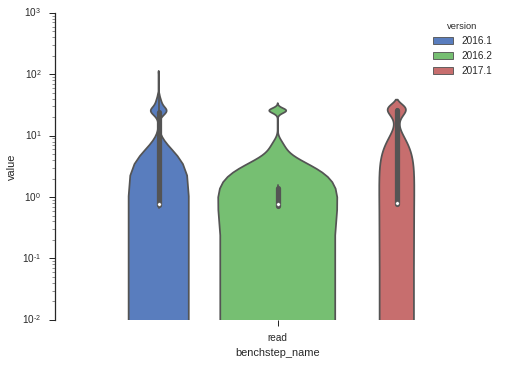

In [10]:
import numpy as np
import seaborn as sns

benchs = df[['value', 'benchstep_name', 'version']]
sns.set(style="ticks", palette="muted", color_codes=True)
ax = sns.violinplot(x="benchstep_name", y="value", hue="version", data=benchs)
ax.set_yscale("log")
sns.despine(trim=True)

In [11]:
from bqplot import *

sc_x = LinearScale()
sc_y = LinearScale()
scatter = Scatter(x=x_data, y=y_data, scales={'x': sc_x, 'y': sc_y}, default_colors=['blue'])

ax_x = Axis(label='Test X', scale=sc_x)
ax_y = Axis(label='Test Y', scale=sc_y, orientation='vertical', tick_format='0.2f')

Figure(axes=[ax_x, ax_y], marks=[scatter])

ImportError: No module named 'bqplot'

In [ ]:
import plotly
from plotly.offline import plot, iplot

fig = {
    'data': [
    ],
    'layout': {
        'xaxis': {'title': 'Revision'},
        'yaxis': {'title': "Time", 'type': 'log'}
    }
}

for version in versions:
    dfversion = df[df.version==version]
    data = { 'x': dfversion["revision"], 
             'y': dfversion["value"], 
             # 'text': df.version, 
             'mode': 'markers', 
             'name': version
            }
    fig["data"].append(data)
   
iplot(fig)